In [38]:
import numpy as np
import pandas as pd
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline

from  sklearn.metrics  import accuracy_score

pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_columns', 500)

In [7]:
#loading data
df_all = pd.read_pickle('df_all.pkl')

In [8]:
df_all.head()

,rating,fullTextHtml
0,4,"<p><span>Wie kam ich zu diesem Buch?</span><br><span>Durch eine Leserunde wurde ich auf das Buch bzw. die Autorin aufmerksam. Ich habe bereits einige Bücher von Regina Mengel gelesen.</span><br><br><span>Wie finde ich Cover und Titel?</span><br><span>Das Cover finde ich ganz witzig, eindeutig ein Frauenroman. Der Titel bereitet auch gleich ein wenig auf die Story vor.</span><br><br><span>Um was geht’s?</span><br><span>Auf den Inhalt gehe ich an dieser Stelle nicht ein, den Klappentext könnt ..."
1,5,"<p><br>Lisa freut sich auf den Tag ihre Lebens ""Ihre Hochzeit"",<br>Doch als es dann endlich soweit ist, und sie gerade am Altar ist,meldet sich Simon.<br><br><br>Simon hat sie vor Monaten einfach so sang und klanglos , von heut auf morgen verlassen.<br>Nie eine Nachricht oder Begründung warum? Wieso?<br>Und gerade am Tag ihrer Hochzeit ,taucht er auch noch in ihrer Kirche zu ihrer Trauung auf.<br>Warum????<br><br><br>Ich fand es klasse,zu erfahren was zu Simons weggang,also alles was vor der..."
2,5,"<p><strong>Klappentext:</strong><br><br>Weg ist er … Ohne ein Wort des Abschieds. Lisa kann es nicht fassen. Sollte Simon sie wirklich aus Eifersucht auf ein Huhn verlassen haben? Eine Antwort bekommt sie nicht, denn Simon bleibt verschwunden. Einige Monate später tritt David in ihr Leben. Er gefällt ihr auf Anhieb, vor allem, da er sich als das genaue Gegenteil von Simon erweist. Auch David scheint sich verliebt zu haben, denn schon bald macht er Lisa einen Heiratsantrag. Oder sollte doch e..."
3,5,"<p>Überraschungen auf einer Hochzeit sind ja an der Tagesordnung, aber den Ex mit dem Lieblingshuhn auf dem Arm zu sehen, gehört nicht dazu. Lisas Hochzeit mit Daniel steht unter keinem guten Stern, denn Simon, Lisas Ex steht plötzlich mitten in der Kirche. Im Arm hält er Lisas Samstagshuhn Antje, sie war der Grund der Trennung.<br>Was führt Simon im Schilde?<br>Nachdem Simon ohne eine Wort zu sagen verschwunden ist, taucht in Lisas Leben Daniel auf. Er ist das komplette Gegenteil von Simon ..."
4,4,"<p><strong>Klappentext:</strong><br>Als David vor Lisa auf die Knie geht und sie bittet seine Frau zu werden, scheint ihr Glück perfekt. Doch warum muss sie immerzu an Simon, ihren Exfreund, denken? Ausgerechnet Simon, der sie – eifersüchtig auf ihr Lieblingshuhn – ohne ein Abschiedswort verlassen hat. <br> <br>Schluss mit Liebeskummer! Lange genug hat sie dem Mistkerl hinterher geweint. Lisa, die sich gern in peinliche bis katastrophale Situationen plappert, die nicht geradeaus sondern mind..."


In [9]:
#changing 'rating' column to integer
df_all['rating'] = df_all['rating'].astype(int)

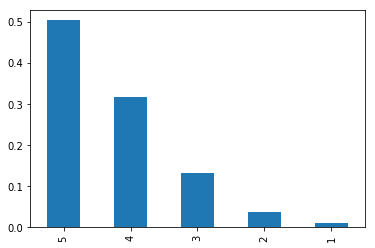

In [10]:
#checking the distribution of classes
#we can see that most of data is rated 5 or 4 and there is really small number of 1's and 2's
#that might be a problem for the model, but let's check the concept
df_all['rating'].value_counts(normalize=True).plot(kind='bar');

In [11]:
df_all['rating'].value_counts(normalize=True)

5    0.503003
4    0.315837
3    0.131619
2    0.038461
1    0.011079
Name: rating, dtype: float64

In [12]:
df_all['rating'].value_counts()

5    181055
4    113685
3     47376
2     13844
1      3988
Name: rating, dtype: int64

In [13]:
df_1_rating = df_all[df_all['rating'] == 1]
df_2_rating = df_all[df_all['rating'] == 2]
df_3_rating = df_all[df_all['rating'] == 3]
df_4_rating = df_all[df_all['rating'] == 4]
df_5_rating = df_all[df_all['rating'] == 5]

In [17]:
df_negativ = pd.DataFrame()
df_negativ = df_negativ.append(df_1_rating)
df_negativ = df_negativ.append(df_2_rating)
df_negativ.shape

(17832, 2)

In [18]:
df_positiv = pd.DataFrame()
df_positiv = df_positiv.append(df_4_rating)
df_positiv = df_positiv.append(df_5_rating)
df_positiv = df_positiv.sample(n=17832)
df_positiv.shape

(17832, 2)

In [20]:
df_all = pd.DataFrame()
df_all = df_all.append(df_negativ)
df_all = df_all.append(df_positiv)
df_all.shape

(35664, 2)

In [27]:
df_all['sentiment'] = df_all['rating'].map(lambda x: 0 if x<3 else 1)

In [28]:
df_all.sample(5)

,rating,fullTextHtml,sentiment
41166,2,"<p></p>\n<p>Handlung:</p>\n<p>Die Geschwister Cal und Yvannie finden ein Mädchen ohne Gedächtnis, das sie bei sich aufnehmen und Elea nennen. Dabei wird nach und nach klar, dass Elea kein normales Mädchen und die Magie real ist. Doch die Dunkelheit versucht an die Macht zu kommen und nur Elea kann mit Hilfe von Cal, Yvannie und anderen Reisegefährten, denen sie begegnet, kann sie aufhalten. Wird sich Elea wieder erinnern können und sind wirklich alle Gefährten auf ihrer Seite?</p>\n<p><br></...",0
271650,2,"<p></p>\n<div>\n Inhalt:\n</div>\n<div>\n Annie McKay flieht vor ihrem gewalttätigen Ehemann in einen Trailerpark. In ihrem Wohnwagen findet sie ein Handy, das klingelt und an das sie ran geht. Der Mann am anderen Ende der Leitung erweckt nie dagewesene Gefühle in Annie und lässt sie Dinge tun, die sie nie für möglich gehalten hat.\n</div>\n<div> \n <br>\n</div>\n<div>\n Meine Meinung:\n</div>\n<div>\n Das Cover hat mich sofort sehr angesprochen, da die Details des Titels wirklich schön ...",0
164862,4,"<p>Deckblatt:<br><br><br>Der Mörder seiner Tochter Kommissar Seeberg aus Fulda geht einen schweren Gang. Ein todkranker Serienmörder ruft ihn zu sich ins Gefängnis. Petrov soll in der Rhön vier Frauen heimtückisch ermordet haben, darunter Seebergs dreizehnjährige Tochter. Doch nun, den Tod vor Augen, erklärt Petrov, jemand anders habe ihn kopiert und Seebergs Tochter umgebracht. Sein Anwalt wisse mehr. Seeberg beginnt in eigener Sache zu ermitteln Doch der Anwalt kann ihm nicht helfen: Er wi...",1
104626,4,"<p></p>\n<p>Kochen ist eine Leidenschaft. Genießen ist eine Kunst. </p>\n<p>An dieses Zitat fühle ich mich erinnert, wenn ich den Roman ""Der Duft von Rosmarin und Schokolade"" von Tania Schie in die Hand nehme. Erzählt wird die Geschichte von Maylis, die taglich hinter der Theke des&nbsp;traditionsreichen Hamburger Feinkostladens Radke&nbsp;steht.&nbsp;Sie genießt es, ihre Kunden zu beraten, nicht nur in kulinarischen, sondern auch in romantischen Angelegenheiten. Doch wenn sie nach Hause kom...",1
33415,2,"<p></p>\n<p>Die D-Bags haben es geschafft. Sie sind über Nacht berühmt geworden und dürfen gemeinsam mit Sienna Sexton, einem Superstar, auf Tour. Doch das neue Leben als Promi birgt auch seine Schattenseiten und so sehen sich Kiera und Kellan bald einem regelrechten Spießroutenlauf ausgesetzt. Zumal Kiera gerne weiterhin im Hintergrund bleiben möchte. Und auch Anna und Griffin müssen sich entscheiden, in welche Richtung ihre Beziehung gehen soll. Werden die neuen Superstars ihren Frauen tre...",0


In [30]:
X = df_all['fullTextHtml'].values
y = df_all['sentiment'].values

skf = StratifiedKFold(n_splits=2, random_state=8888, shuffle=True)
skf.get_n_splits(X, y)

2

In [31]:
for train_index, test_index in skf.split(X, y):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17832,), (17832,), (17832,), (17832,))

In [33]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([8916, 8916], dtype=int64))

In [34]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int64), array([8916, 8916], dtype=int64))

In [35]:
#bag of words
#Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, 
#which builds a dictionary of features and transforms documents to feature vectors

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(17832, 145584)

In [36]:
#checking some typical words if they are in vocabulary
count_vect.vocabulary_.get('wunderbar')

139304

In [37]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(17832, 145584)

NAIVE BAYES

In [45]:
#training a Naive Bayes classifier
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [48]:
#testing on some simple examples
docs_new = ['Film war wunderbar', 'Das Film was schrecklich']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

In [49]:
predicted = clf.predict(X_new_tfidf)
predicted

array([1, 0], dtype=int64)

In [50]:
#In order to make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class
#that behaves like a compound classifier

text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
 ])

In [51]:
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [52]:
#evaluation on test set
predicted = text_clf.predict(X_test)
print(accuracy_score(y_test,predicted))

0.8741027366532077


SVM

In [53]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=8888,
                          max_iter=5, tol=None)),
])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
print(accuracy_score(y_test,predicted))

0.8618214445939884


In [58]:
#more detailed metrics
print(metrics.classification_report(y_test, predicted, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.92      0.80      0.85      8916
           1       0.82      0.93      0.87      8916

    accuracy                           0.86     17832
   macro avg       0.87      0.86      0.86     17832
weighted avg       0.87      0.86      0.86     17832



XGBOOST

In [59]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', xgb.XGBClassifier(random_state=8888,max_depth=5, n_estimators=100, objective='multi:softmax', num_class=2)),
])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
print(accuracy_score(y_test,predicted))

0.8755607895917452


In [ ]:
#more detailed metrics
print(metrics.classification_report(y_test, predicted, target_names=['0','1']))